In [1]:
import math
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import random
from torch.autograd import Variable
from matplotlib import pyplot as plt
import seaborn as sns
from torch import nn
from collections import OrderedDict
from torch.utils.data import DataLoader

import torchmetrics

import optuna

from tqdm import tqdm

import time
import plotly.graph_objects as go
import os

from torchviz import make_dot, make_dot_from_trace

/home/hudson/Unifei/TCC/codigos/EDPs_Neural_network/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from Loss import Loss
from Net import Net

In [3]:
torch.set_default_dtype(torch.float64)

In [4]:
def metricas(net, sol_eq, a, b):
    """Calcula a o erro médio quadrado e o erro médio
    absoluto de uma rede neural.

    Parameters
    ----------
    net : _type_
        Rede neural
    sol_eq : _type_
        Função da equação analítica
    a : int
        _description_
    b : int
        _description_

    Returns
    -------
    Tuple
        Erro médio quadrado e erro médio absoluto
    """
    xx = torch.linspace(0, a, 100)
    yy = torch.linspace(0, b, 100)

    xx, yy = torch.meshgrid(xx, yy, indexing='xy')

    xx = xx.reshape((xx.shape[0]**2, 1))
    yy = yy.reshape((yy.shape[0]**2, 1))

    sol = sol_eq(xx, yy)
    prev = net.predict(torch.cat([xx, yy], axis=1))

    return torchmetrics.functional.mean_squared_error(sol, prev),\
           torchmetrics.functional.mean_absolute_error(sol, prev)

In [5]:
def plot_solucao_erro_l2(net, sol_eq, a, b):
    xx = torch.linspace(0, a, 100)
    yy = torch.linspace(0, b, 100)

    xx, yy = torch.meshgrid(xx, yy, indexing='xy')

    xx = xx.reshape((xx.shape[0]**2, 1))
    yy = yy.reshape((yy.shape[0]**2, 1))

    sol = sol_eq(xx, yy)
    prev = net.predict(torch.cat([xx, yy], axis=1))

    prev = prev.reshape((100, 100))
    sol = sol.reshape((100, 100))
    xx = xx.reshape((100, 100))
    yy = yy.reshape((100, 100))

    #plot
    fig1, ax = plt.subplots(1, 2, figsize=(20,7))

    img1 = ax[0].pcolor(xx.numpy(), yy.numpy(), sol.numpy(), vmin=sol.min(), vmax=sol.max())
    fig1.colorbar(img1, ax=ax[0])
    ax[0].set_title('Solução Analítica')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')

    img2 = ax[1].pcolor(xx.numpy(), yy.numpy(), prev.numpy(), vmin=sol.min(), vmax=sol.max())
    fig1.colorbar(img2, ax=ax[1])

    ax[1].set_title('Solução numérica obtida pela rede neural1')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    #plt.show()

    # Plot erro L2
    fig, ax = plt.subplots(1, 1, figsize=(7,5))

    img1 = ax.pcolor(xx.numpy(), yy.numpy(), abs(prev.numpy() - sol.numpy()))
    fig.colorbar(img1, ax=ax)
    ax.set_title('Erro L2')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    #plt.show()

    return fig1, fig


# Gráficos

In [6]:
def plot_convergencia(epochs_array, loss_array):
  loss = np.array(loss_array).sum(axis=1)

  fig = plt.figure(figsize=(10, 5))
  ax = sns.lineplot(x=epochs_array, y=loss)
  # Configurar os labels do eixo x e y
  plt.xlabel('Épocas')
  plt.ylabel('Loss')
  plt.title('Gráfico de Convergência')

  return fig

# Treino

In [7]:
### Amostra para entrada:
### L: tamanho da amostra
# np.random.seed(42)
# Laplace
L=100
a = 3
b = 2
# Calor
a = 40
b = 10
# Onda 2
a = 1
b = 1
x = np.random.uniform(0,a, size=L) ##
t = np.random.uniform(0,b, size=L)

# joblib.dump(x, PATH + 'x.pkl')
# joblib.dump(t, PATH + 't.pkl')

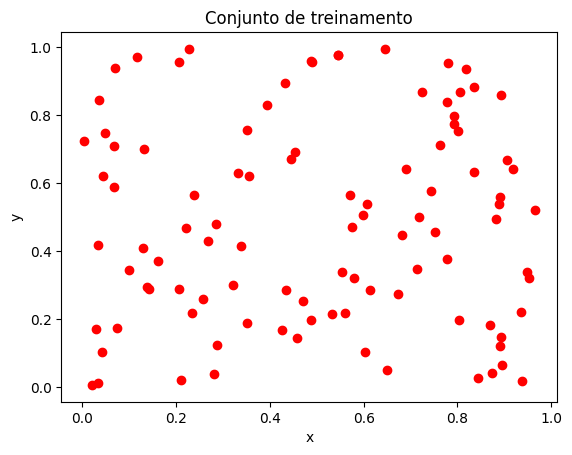

In [8]:
# x = joblib.load(PATH + 'x.pkl')
# t = joblib.load(PATH + 't.pkl')

plt.plot(x, t, 'or')
#plt.plot(dom_pred, im_pred, 'or')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Conjunto de treinamento')
plt.show()

In [9]:
# Convertendo para tensor
x = np.expand_dims(x, axis=0)
t = np.expand_dims(t, axis=0)

inp = torch.tensor(np.concatenate([x, t]).T, requires_grad=True)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


In [11]:
net = Net.Net(layers=[2, 10, 10, 10, 10, 1],
              activation_functions=[nn.SiLU]*4,
              loss=Loss.LossOnda2(taxa_aceleracao=1), # Loss.LossLaplace(taxa_aceleracao=1),
              optimizer=optim.Adamax,
              optimizer_params={'lr': 0.001},
              device=device)

In [12]:
nt = net.net
nt.parameters

<bound method Module.parameters of Model(
  (features): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): SiLU()
  )
  (hidden): Sequential(
    (linear1): Linear(in_features=10, out_features=10, bias=True)
    (activaction function 1): SiLU()
    (linear2): Linear(in_features=10, out_features=10, bias=True)
    (activaction function 2): SiLU()
    (linear3): Linear(in_features=10, out_features=10, bias=True)
    (activaction function 3): SiLU()
  )
  (out): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)>

In [13]:
epochs_array, loss_array = net.fit(x=inp, epochs=5000, nbatches=1, output_loss=True)

Epoch 1000, Loss 18.253510508486144
Epoch 2000, Loss 0.3619081417316854
Epoch 3000, Loss 0.040109250662814934
Epoch 4000, Loss 0.026531453478941806
Epoch 5000, Loss 0.020596269109241713


In [14]:
# metricas(net, Loss.solution_laplace, a, b)
metricas(net, Loss.solution_onda_2, a, b)

(tensor(1.2734e-05), tensor(0.0030))

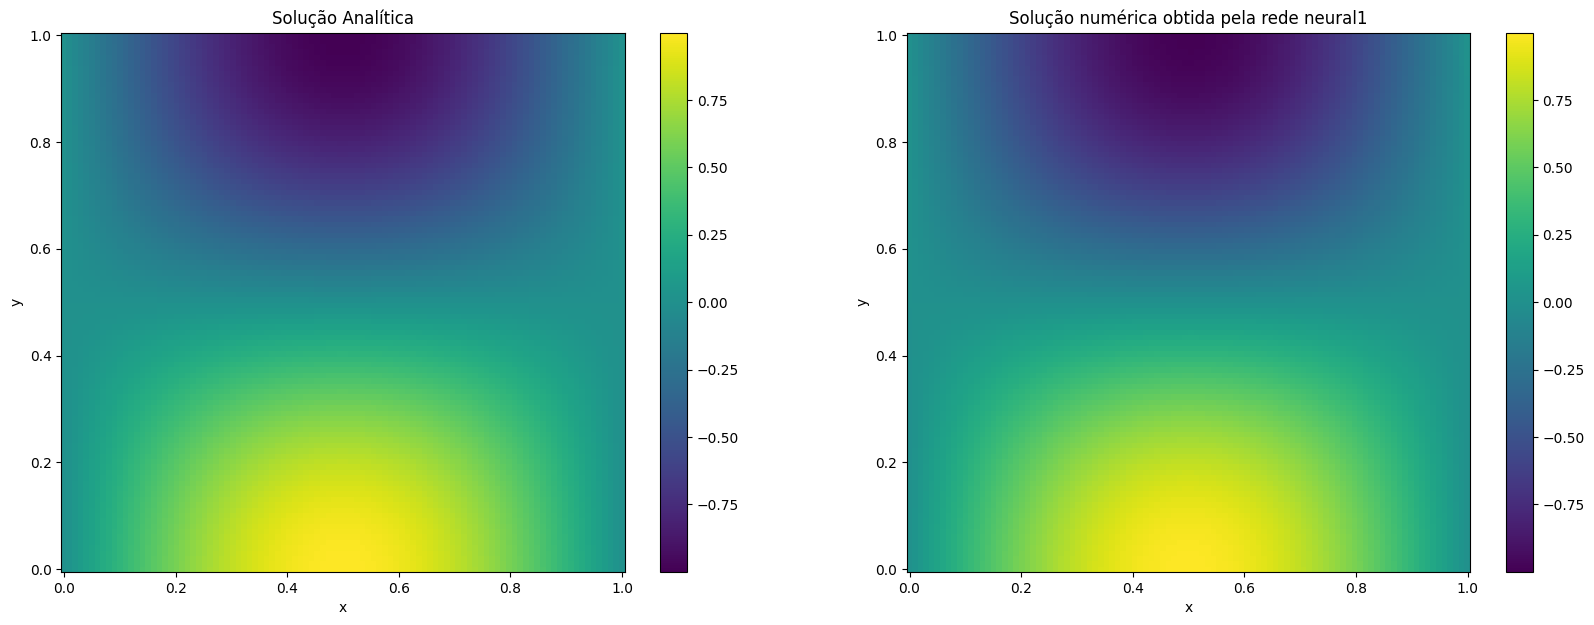

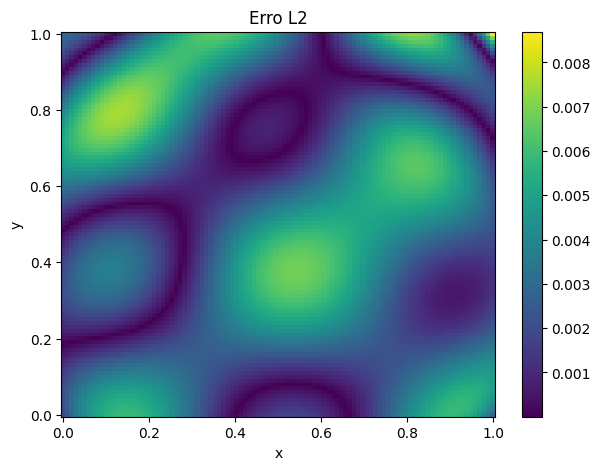

In [16]:
# fig1, fig2 = plot_solucao_erro_l2(net, Loss.solution_laplace, a, b)
fig1, fig2 = plot_solucao_erro_l2(net, Loss.solution_onda_2, a, b)

# Otimizando

In [36]:
def objective(trial):
   # Define the search space for the hyperparameters
    n_layers = trial.suggest_int('n_layers', 1, 10)
    layer_sizes = [trial.suggest_int(f'layer_{i}_size', 1, 30) for i in range(n_layers)]
    activations = [trial.suggest_categorical(f'layer_{i}_activation', ['relu', 'tanh', 'silu']) for i in range(n_layers)]
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-10, 1e-3, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop', 'Adamax'])
    num_epochs = trial.suggest_int('num_epochs', 1, 30000)
    batch_size = trial.suggest_int('batch_size', 1, 10)
    taxa_aceleracao = trial.suggest_categorical(f'taxa de aceleração', [1, 1e-3])

    # Define the model architecture
    layers = [2] + layer_sizes + [1]
    activations_list = []
    for i in range(n_layers):
        activation = activations[i]
        if activation == 'relu':
            activations_list.append(nn.ReLU)
        elif activation == 'silu':
            activations_list.append(nn.SiLU)
        elif activation == 'tanh':
            activations_list.append(nn.Tanh)

     # Define the optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop
    elif optimizer_name == 'Adamax':
        optimizer = optim.Adamax

    net = Net.Net(layers=layers,
                  activation_functions=activations_list,
                  loss=Loss.LossLaplace(taxa_aceleracao=taxa_aceleracao),
                  optimizer=optimizer,
                  optimizer_params={'lr': learning_rate,
                                    'weight_decay': weight_decay},
                  device=device)

    epochs_array, loss_array = net.fit(x=inp, epochs=num_epochs, nbatches=batch_size, output_loss=True)

    mse, mae = metricas(net, Loss.solution_laplace, a, b)

    return float(mse)

In [37]:
import joblib

In [38]:
try:
    study = joblib.load('pickle_data/study.pkl')
except:
    study = optuna.create_study(direction='minimize')

[I 2023-10-09 22:21:46,109] A new study created in memory with name: no-name-8097967d-e9c2-45e3-8426-77f893d80b90


In [39]:
for i in range(1000):
    study.optimize(objective, n_trials=1)
    joblib.dump(study, 'pickle_data/study.pkl')

Epoch 1000, Loss 1.848055156100639
Epoch 2000, Loss 1.505789017762867
Epoch 3000, Loss 1.1931798219551961
Epoch 4000, Loss 0.8407038086791021
Epoch 5000, Loss 0.5781088549992668
Epoch 6000, Loss 0.4514911808583808
Epoch 7000, Loss 0.37927361572894336
Epoch 8000, Loss 0.3394396926921608
Epoch 9000, Loss 0.2786071878228677
Epoch 10000, Loss 0.2620975948613532
Epoch 11000, Loss 0.24051761220802198
Epoch 12000, Loss 0.23342480585868602
Epoch 13000, Loss 0.22272964165348014
Epoch 14000, Loss 0.23064836976103226
Epoch 15000, Loss 0.2303239405228322
Epoch 16000, Loss 0.21509305514256605
Epoch 17000, Loss 0.18537450385347642
Epoch 18000, Loss 0.18014924135941673
Epoch 19000, Loss 0.18934157566742893
Epoch 20000, Loss 0.17510043459043942
Epoch 21000, Loss 0.1705811898460085
Epoch 22000, Loss 0.17480552108787764
Epoch 23000, Loss 0.175268663389127


[I 2023-10-09 22:58:47,212] Trial 0 finished with value: 0.03555608981190821 and parameters: {'n_layers': 3, 'layer_0_size': 10, 'layer_1_size': 29, 'layer_2_size': 28, 'layer_0_activation': 'tanh', 'layer_1_activation': 'relu', 'layer_2_activation': 'tanh', 'learning_rate': 1.9835516963643354e-05, 'weight_decay': 2.384994566448677e-05, 'optimizer': 'RMSprop', 'num_epochs': 23607, 'batch_size': 10, 'taxa de aceleração': 1}. Best is trial 0 with value: 0.03555608981190821.


Epoch 1000, Loss 6.156264374430871
Epoch 2000, Loss 6.156264374430871
Epoch 3000, Loss 6.156264374430871
Epoch 4000, Loss 6.156264374430871
Epoch 5000, Loss 6.156264374430871
Epoch 6000, Loss 6.156264374430871
Epoch 7000, Loss 6.156264374430871
Epoch 8000, Loss 6.156264374430871
Epoch 9000, Loss 6.156264374430871
Epoch 10000, Loss 6.156264374430871
Epoch 11000, Loss 6.156264374430871
Epoch 12000, Loss 6.156264374430871
Epoch 13000, Loss 6.156264374430871
Epoch 14000, Loss 6.156264374430871
Epoch 15000, Loss 6.156264374430871
Epoch 16000, Loss 6.156264374430871
Epoch 17000, Loss 6.156264374430871
Epoch 18000, Loss 6.156264374430871
Epoch 19000, Loss 6.156264374430871
Epoch 20000, Loss 6.156264374430871
Epoch 21000, Loss 6.156264374430871


[I 2023-10-09 23:16:24,023] Trial 1 finished with value: 0.024616743854827566 and parameters: {'n_layers': 7, 'layer_0_size': 4, 'layer_1_size': 16, 'layer_2_size': 6, 'layer_3_size': 30, 'layer_4_size': 22, 'layer_5_size': 15, 'layer_6_size': 24, 'layer_0_activation': 'tanh', 'layer_1_activation': 'tanh', 'layer_2_activation': 'relu', 'layer_3_activation': 'tanh', 'layer_4_activation': 'tanh', 'layer_5_activation': 'tanh', 'layer_6_activation': 'silu', 'learning_rate': 0.000849630196742036, 'weight_decay': 5.473404471289755e-09, 'optimizer': 'SGD', 'num_epochs': 21996, 'batch_size': 4, 'taxa de aceleração': 1}. Best is trial 1 with value: 0.024616743854827566.


Epoch 1000, Loss 2.8915941044744472e-05
Epoch 2000, Loss 5.554619184244688e-05
Epoch 3000, Loss 1.0102617462833909e-05
Epoch 4000, Loss 2.257804244988495e-05
Epoch 5000, Loss 8.568469129178772e-05
Epoch 6000, Loss 0.00010146575935312757
Epoch 7000, Loss 1.9099480465492097e-05
Epoch 8000, Loss 3.7506451498293273e-06
Epoch 9000, Loss 6.341896935781303e-05
Epoch 10000, Loss 8.384222850440675e-05
Epoch 11000, Loss 5.81274071109955e-06
Epoch 12000, Loss 0.0001533680127935715
Epoch 13000, Loss 1.1568901441493721e-05
Epoch 14000, Loss 1.4197841523610217e-05


[I 2023-10-09 23:34:10,782] Trial 2 finished with value: 0.00023058992937667323 and parameters: {'n_layers': 3, 'layer_0_size': 25, 'layer_1_size': 19, 'layer_2_size': 10, 'layer_0_activation': 'silu', 'layer_1_activation': 'tanh', 'layer_2_activation': 'tanh', 'learning_rate': 0.03468323083663553, 'weight_decay': 1.3755949988411547e-07, 'optimizer': 'Adamax', 'num_epochs': 14088, 'batch_size': 10, 'taxa de aceleração': 0.001}. Best is trial 2 with value: 0.00023058992937667323.


Epoch 1000, Loss 0.5513837980972376
Epoch 2000, Loss 0.5414916532689937
Epoch 3000, Loss 0.5851314278167234
Epoch 4000, Loss 0.6605072533082863
Epoch 5000, Loss 0.7093325505603572
Epoch 6000, Loss 0.6417510736759198
Epoch 7000, Loss 0.670946325944034
Epoch 8000, Loss 0.678632767903271
Epoch 9000, Loss 0.5821142351825976
Epoch 10000, Loss 0.9908603707681343
Epoch 11000, Loss 0.6533655628154047
Epoch 12000, Loss 0.6302587540398508


[I 2023-10-09 23:50:03,225] Trial 3 finished with value: 0.01655058283519466 and parameters: {'n_layers': 10, 'layer_0_size': 13, 'layer_1_size': 23, 'layer_2_size': 27, 'layer_3_size': 21, 'layer_4_size': 7, 'layer_5_size': 11, 'layer_6_size': 3, 'layer_7_size': 17, 'layer_8_size': 18, 'layer_9_size': 10, 'layer_0_activation': 'silu', 'layer_1_activation': 'relu', 'layer_2_activation': 'tanh', 'layer_3_activation': 'silu', 'layer_4_activation': 'relu', 'layer_5_activation': 'tanh', 'layer_6_activation': 'silu', 'layer_7_activation': 'relu', 'layer_8_activation': 'tanh', 'layer_9_activation': 'tanh', 'learning_rate': 0.0006476940793487427, 'weight_decay': 6.706054454364039e-06, 'optimizer': 'RMSprop', 'num_epochs': 12779, 'batch_size': 3, 'taxa de aceleração': 1}. Best is trial 2 with value: 0.00023058992937667323.


Epoch 1000, Loss 0.0016584645185267742
Epoch 2000, Loss 0.0008700388252043138
Epoch 3000, Loss 0.0015144006470677305
Epoch 4000, Loss 0.0012245293271972222
Epoch 5000, Loss 0.0016226202453237717
Epoch 6000, Loss 0.001082296594402685
Epoch 7000, Loss 0.00019720473429219728
Epoch 8000, Loss 0.0007060140634889667
Epoch 9000, Loss 0.0010589181278307012
Epoch 10000, Loss 0.0003733866383155612
Epoch 11000, Loss 0.0011526260676497687
Epoch 12000, Loss 0.00013468623346201038
Epoch 13000, Loss 0.0007065148499214508
Epoch 14000, Loss 0.002265607128709026
Epoch 15000, Loss 0.0006241604891025252
Epoch 16000, Loss 0.0002933553137308973
Epoch 17000, Loss 0.0006494544967360455
Epoch 18000, Loss 0.0010235684805885285
Epoch 19000, Loss 0.0003434642754383048
Epoch 20000, Loss 0.0008919114428139947


[I 2023-10-10 00:15:14,497] Trial 4 finished with value: 0.0029522165959344343 and parameters: {'n_layers': 3, 'layer_0_size': 27, 'layer_1_size': 10, 'layer_2_size': 26, 'layer_0_activation': 'relu', 'layer_1_activation': 'tanh', 'layer_2_activation': 'tanh', 'learning_rate': 0.000689929131938679, 'weight_decay': 1.7930388449024773e-06, 'optimizer': 'RMSprop', 'num_epochs': 20432, 'batch_size': 10, 'taxa de aceleração': 0.001}. Best is trial 2 with value: 0.00023058992937667323.


Epoch 1000, Loss 0.004895592662033329
Epoch 2000, Loss 0.03706320779965318
Epoch 3000, Loss 0.004294920004166456
Epoch 4000, Loss 0.0018469233523663732
Epoch 5000, Loss 0.0015127253659418713
Epoch 6000, Loss 0.016058749188534473
Epoch 7000, Loss 0.00029338478143834393
Epoch 8000, Loss 0.0014975759119842985
Epoch 9000, Loss 0.0008621443495071716
Epoch 10000, Loss 0.002286681596062856
Epoch 11000, Loss 0.00017053518223612268
Epoch 12000, Loss 0.0004081429760315557
Epoch 13000, Loss 0.0022012430017730915
Epoch 14000, Loss 0.00021523416608185426
Epoch 15000, Loss 0.0008331371346422412
Epoch 16000, Loss 0.008880897960126434
Epoch 17000, Loss 0.0009934282170865813
Epoch 18000, Loss 0.005614083973290799
Epoch 19000, Loss 0.0002967428979158135
Epoch 20000, Loss 0.0001884166477984522
Epoch 21000, Loss 0.00016930925962604565
Epoch 22000, Loss 0.00020002445956006408


[I 2023-10-10 01:06:10,834] Trial 5 finished with value: 1.5452192139980156e-05 and parameters: {'n_layers': 8, 'layer_0_size': 15, 'layer_1_size': 22, 'layer_2_size': 6, 'layer_3_size': 21, 'layer_4_size': 14, 'layer_5_size': 28, 'layer_6_size': 7, 'layer_7_size': 13, 'layer_0_activation': 'silu', 'layer_1_activation': 'silu', 'layer_2_activation': 'silu', 'layer_3_activation': 'tanh', 'layer_4_activation': 'tanh', 'layer_5_activation': 'silu', 'layer_6_activation': 'silu', 'layer_7_activation': 'silu', 'learning_rate': 0.01743784675087206, 'weight_decay': 5.404118367703678e-09, 'optimizer': 'Adamax', 'num_epochs': 22348, 'batch_size': 9, 'taxa de aceleração': 1}. Best is trial 5 with value: 1.5452192139980156e-05.


Epoch 1000, Loss 22.73717305191128
Epoch 2000, Loss 18.181088939548403
Epoch 3000, Loss 16.049226944792018
Epoch 4000, Loss 15.968174779070754
Epoch 5000, Loss 15.793219762727102
Epoch 6000, Loss 16.2686100142938
Epoch 7000, Loss 16.381363846210206
Epoch 8000, Loss 16.35512166627456
Epoch 9000, Loss 17.515424149735978
Epoch 10000, Loss 17.48108292112901
Epoch 11000, Loss 18.304424949042648
Epoch 12000, Loss 18.9739026775097
Epoch 13000, Loss 18.799143043036096
Epoch 14000, Loss 18.716553551270756
Epoch 15000, Loss 19.580491162894038
Epoch 16000, Loss 19.697230664681484
Epoch 17000, Loss 19.380128028750427


[I 2023-10-10 01:12:03,442] Trial 6 finished with value: 0.021949568220163838 and parameters: {'n_layers': 10, 'layer_0_size': 24, 'layer_1_size': 3, 'layer_2_size': 18, 'layer_3_size': 16, 'layer_4_size': 6, 'layer_5_size': 22, 'layer_6_size': 2, 'layer_7_size': 16, 'layer_8_size': 1, 'layer_9_size': 20, 'layer_0_activation': 'tanh', 'layer_1_activation': 'tanh', 'layer_2_activation': 'relu', 'layer_3_activation': 'tanh', 'layer_4_activation': 'relu', 'layer_5_activation': 'silu', 'layer_6_activation': 'relu', 'layer_7_activation': 'silu', 'layer_8_activation': 'tanh', 'layer_9_activation': 'relu', 'learning_rate': 0.00018410422398167824, 'weight_decay': 2.18534670121101e-09, 'optimizer': 'RMSprop', 'num_epochs': 17768, 'batch_size': 1, 'taxa de aceleração': 1}. Best is trial 5 with value: 1.5452192139980156e-05.


Epoch 1000, Loss 0.026306852494553723
Epoch 2000, Loss 0.02613151058538137
Epoch 3000, Loss 0.02596715410534098
Epoch 4000, Loss 0.02581309121557412
Epoch 5000, Loss 0.025668674072950464
Epoch 6000, Loss 0.025533295981708753
Epoch 7000, Loss 0.025406388735494022
Epoch 8000, Loss 0.025287420136424533
Epoch 9000, Loss 0.0251758916786415
Epoch 10000, Loss 0.025071336385046786
Epoch 11000, Loss 0.024973316786502317
Epoch 12000, Loss 0.024881423033721366
Epoch 13000, Loss 0.02479527113276076


[I 2023-10-10 01:16:55,013] Trial 7 finished with value: 0.026840326161407576 and parameters: {'n_layers': 10, 'layer_0_size': 3, 'layer_1_size': 21, 'layer_2_size': 23, 'layer_3_size': 10, 'layer_4_size': 9, 'layer_5_size': 7, 'layer_6_size': 19, 'layer_7_size': 5, 'layer_8_size': 26, 'layer_9_size': 28, 'layer_0_activation': 'silu', 'layer_1_activation': 'relu', 'layer_2_activation': 'silu', 'layer_3_activation': 'silu', 'layer_4_activation': 'silu', 'layer_5_activation': 'tanh', 'layer_6_activation': 'tanh', 'layer_7_activation': 'silu', 'layer_8_activation': 'silu', 'layer_9_activation': 'tanh', 'learning_rate': 2.166748267895056e-05, 'weight_decay': 7.266077743494295e-07, 'optimizer': 'SGD', 'num_epochs': 13632, 'batch_size': 1, 'taxa de aceleração': 0.001}. Best is trial 5 with value: 1.5452192139980156e-05.


Epoch 1000, Loss 0.0007060514027650481
Epoch 2000, Loss 0.0007049116607902019
Epoch 3000, Loss 0.000702462474613283
Epoch 4000, Loss 0.0007012731405349601


[I 2023-10-10 01:24:48,837] Trial 8 finished with value: 0.013033178344868753 and parameters: {'n_layers': 6, 'layer_0_size': 15, 'layer_1_size': 8, 'layer_2_size': 9, 'layer_3_size': 6, 'layer_4_size': 2, 'layer_5_size': 14, 'layer_0_activation': 'tanh', 'layer_1_activation': 'silu', 'layer_2_activation': 'tanh', 'layer_3_activation': 'tanh', 'layer_4_activation': 'tanh', 'layer_5_activation': 'relu', 'learning_rate': 6.540831151766023e-05, 'weight_decay': 5.160037054506714e-08, 'optimizer': 'Adamax', 'num_epochs': 4736, 'batch_size': 8, 'taxa de aceleração': 0.001}. Best is trial 5 with value: 1.5452192139980156e-05.


Epoch 1000, Loss 0.00018495355183334244
Epoch 2000, Loss 9.856796391242626e-05
Epoch 3000, Loss 0.0001457293509926021
Epoch 4000, Loss 6.0107101456185805e-05
Epoch 5000, Loss 6.430742740614713e-05
Epoch 6000, Loss 4.6364679695662037e-05
Epoch 7000, Loss 4.224295996860427e-05
Epoch 8000, Loss 4.7663040545349095e-05
Epoch 9000, Loss 4.102963621985756e-05
Epoch 10000, Loss 3.2345255461519807e-05
Epoch 11000, Loss 1.8475730671788165e-05
Epoch 12000, Loss 1.569483509290178e-05
Epoch 13000, Loss 2.0597056383569993e-05
Epoch 14000, Loss 3.58942243750967e-05
Epoch 15000, Loss 2.0735520762768734e-05


[I 2023-10-10 01:32:05,915] Trial 9 finished with value: 0.001150085733773785 and parameters: {'n_layers': 3, 'layer_0_size': 20, 'layer_1_size': 5, 'layer_2_size': 1, 'layer_0_activation': 'tanh', 'layer_1_activation': 'silu', 'layer_2_activation': 'tanh', 'learning_rate': 0.006478626285910495, 'weight_decay': 2.501187519166048e-05, 'optimizer': 'RMSprop', 'num_epochs': 15153, 'batch_size': 3, 'taxa de aceleração': 0.001}. Best is trial 5 with value: 1.5452192139980156e-05.


Epoch 1000, Loss 0.7538829262673711
Epoch 2000, Loss 0.8002515353065028
Epoch 3000, Loss 0.7565538929110169
Epoch 4000, Loss 2.099398457768182
Epoch 5000, Loss 2.0993991577318787
Epoch 6000, Loss 2.0993991577319413
Epoch 7000, Loss 2.0993993063157834
Epoch 8000, Loss 2.099399157731896
Epoch 9000, Loss 2.099399157732077
Epoch 10000, Loss 2.0993991577352213
Epoch 11000, Loss 2.099399157739031
Epoch 12000, Loss 2.0993991577415256
Epoch 13000, Loss 2.0993991577414337
Epoch 14000, Loss 2.0993991577414497
Epoch 15000, Loss 2.0993991577414413
Epoch 16000, Loss 2.0993991577414173
Epoch 17000, Loss 2.0993991577414235
Epoch 18000, Loss 2.099399157741419
Epoch 19000, Loss 2.099399157741419
Epoch 20000, Loss 2.099399157741438
Epoch 21000, Loss 2.0993991577414164
Epoch 22000, Loss 2.0993991577414466
Epoch 23000, Loss 2.0993991577414395
Epoch 24000, Loss 2.099399157741419
Epoch 25000, Loss 2.099399157741426
Epoch 26000, Loss 2.0993991577414235
Epoch 27000, Loss 2.0993991577414164


[I 2023-10-10 02:23:02,249] Trial 10 finished with value: 0.49723748798142414 and parameters: {'n_layers': 8, 'layer_0_size': 9, 'layer_1_size': 30, 'layer_2_size': 16, 'layer_3_size': 25, 'layer_4_size': 18, 'layer_5_size': 30, 'layer_6_size': 10, 'layer_7_size': 30, 'layer_0_activation': 'relu', 'layer_1_activation': 'silu', 'layer_2_activation': 'silu', 'layer_3_activation': 'relu', 'layer_4_activation': 'tanh', 'layer_5_activation': 'silu', 'layer_6_activation': 'silu', 'layer_7_activation': 'tanh', 'learning_rate': 0.08473869994801203, 'weight_decay': 2.1015828979257312e-10, 'optimizer': 'Adam', 'num_epochs': 27825, 'batch_size': 7, 'taxa de aceleração': 1}. Best is trial 5 with value: 1.5452192139980156e-05.


Epoch 1000, Loss 0.0006553172037018809
Epoch 2000, Loss 0.0006553599253160175
Epoch 3000, Loss 0.0006553151069131136
Epoch 4000, Loss 0.0006554071098476085
Epoch 5000, Loss 0.0006553016631931775
Epoch 6000, Loss 0.0006552972080521511


[I 2023-10-10 02:27:36,094] Trial 11 finished with value: 0.011131616034687854 and parameters: {'n_layers': 1, 'layer_0_size': 30, 'layer_0_activation': 'silu', 'learning_rate': 0.02174786751841193, 'weight_decay': 0.0005549701443932939, 'optimizer': 'Adamax', 'num_epochs': 6229, 'batch_size': 8, 'taxa de aceleração': 0.001}. Best is trial 5 with value: 1.5452192139980156e-05.


Epoch 1000, Loss 0.00010121487072215999
Epoch 2000, Loss 0.0017943782884852094
Epoch 3000, Loss 0.0026098801192325095
Epoch 4000, Loss 0.0015603664912394112
Epoch 5000, Loss 0.0014808581124096955
Epoch 6000, Loss 0.0017384381951449674
Epoch 7000, Loss 0.001938764214923157
Epoch 8000, Loss 0.002042899948249223
Epoch 9000, Loss 0.0017957254950430497
Epoch 10000, Loss 0.001792581592174856
Epoch 11000, Loss 0.0009798593741418365
Epoch 12000, Loss 0.0024181416647081856
Epoch 13000, Loss 0.001229329014438498
Epoch 14000, Loss 0.0015178790809575863
Epoch 15000, Loss 0.0017268045140584804
Epoch 16000, Loss 0.0011123247130773927
Epoch 17000, Loss 0.0011508062012814246
Epoch 18000, Loss 0.0015920245604122655
Epoch 19000, Loss 0.0014268616302167345
Epoch 20000, Loss 0.0012384118094401163
Epoch 21000, Loss 0.0010551912873221726
Epoch 22000, Loss 0.001299930132047815
Epoch 23000, Loss 0.0019097968895007522
Epoch 24000, Loss 0.0008672289866846091
Epoch 25000, Loss 0.001972442268120861
Epoch 26000, L

[I 2023-10-10 03:17:24,247] Trial 12 finished with value: 0.00222291300756396 and parameters: {'n_layers': 5, 'layer_0_size': 20, 'layer_1_size': 17, 'layer_2_size': 10, 'layer_3_size': 15, 'layer_4_size': 26, 'layer_0_activation': 'silu', 'layer_1_activation': 'tanh', 'layer_2_activation': 'silu', 'layer_3_activation': 'relu', 'layer_4_activation': 'silu', 'learning_rate': 0.006017560270461745, 'weight_decay': 1.1150374656877153e-07, 'optimizer': 'Adamax', 'num_epochs': 29927, 'batch_size': 10, 'taxa de aceleração': 0.001}. Best is trial 5 with value: 1.5452192139980156e-05.


Epoch 1000, Loss 0.04951491181224789
Epoch 2000, Loss 0.011616393503842276
Epoch 3000, Loss 0.012440335680363929
Epoch 4000, Loss 0.042645425162255474
Epoch 5000, Loss 0.03012878651257927
Epoch 6000, Loss 0.017164475376098054
Epoch 7000, Loss 0.02056754988189489
Epoch 8000, Loss 0.002736615404262034
Epoch 9000, Loss 0.00727458977421582


[I 2023-10-10 03:28:21,431] Trial 13 finished with value: 0.00024325772329464326 and parameters: {'n_layers': 5, 'layer_0_size': 20, 'layer_1_size': 23, 'layer_2_size': 2, 'layer_3_size': 1, 'layer_4_size': 15, 'layer_0_activation': 'silu', 'layer_1_activation': 'silu', 'layer_2_activation': 'silu', 'layer_3_activation': 'tanh', 'layer_4_activation': 'tanh', 'learning_rate': 0.06473569883373693, 'weight_decay': 2.0176445370710915e-08, 'optimizer': 'Adamax', 'num_epochs': 9449, 'batch_size': 6, 'taxa de aceleração': 1}. Best is trial 5 with value: 1.5452192139980156e-05.


Epoch 1000, Loss 0.0006815920627558742
Epoch 2000, Loss 0.023644222580094236
Epoch 3000, Loss 0.0013399397911046625
Epoch 4000, Loss 0.017948867541318917
Epoch 5000, Loss 0.0007760294784473149
Epoch 6000, Loss 0.0007080997630787927
Epoch 7000, Loss 0.0014632630853430246
Epoch 8000, Loss 0.0007900792403876078
Epoch 9000, Loss 0.0011920946073284804
Epoch 10000, Loss 0.0008244773673311192
Epoch 11000, Loss 0.000783513778318242
Epoch 12000, Loss 0.00042304821650629995
Epoch 13000, Loss 0.0001075604571670344
Epoch 14000, Loss 0.0011115408992672634
Epoch 15000, Loss 0.0005060862533587168
Epoch 16000, Loss 0.0009186154683890788
Epoch 17000, Loss 0.0007459404820363225
Epoch 18000, Loss 0.0019321957949321187
Epoch 19000, Loss 0.0008503532074052481
Epoch 20000, Loss 0.00032077190724302004
Epoch 21000, Loss 0.0013784080942343066
Epoch 22000, Loss 0.0003295540387191776
Epoch 23000, Loss 0.00023838621864726652


[I 2023-10-10 04:17:11,597] Trial 14 finished with value: 0.0006269268612372551 and parameters: {'n_layers': 8, 'layer_0_size': 23, 'layer_1_size': 13, 'layer_2_size': 12, 'layer_3_size': 21, 'layer_4_size': 13, 'layer_5_size': 28, 'layer_6_size': 12, 'layer_7_size': 4, 'layer_0_activation': 'silu', 'layer_1_activation': 'silu', 'layer_2_activation': 'silu', 'layer_3_activation': 'tanh', 'layer_4_activation': 'tanh', 'layer_5_activation': 'silu', 'layer_6_activation': 'relu', 'layer_7_activation': 'silu', 'learning_rate': 0.009590330130500138, 'weight_decay': 1.0075322478155533e-09, 'optimizer': 'Adamax', 'num_epochs': 23941, 'batch_size': 8, 'taxa de aceleração': 0.001}. Best is trial 5 with value: 1.5452192139980156e-05.
[I 2023-10-10 04:17:15,341] Trial 15 finished with value: 0.0036934101633142005 and parameters: {'n_layers': 1, 'layer_0_size': 17, 'layer_0_activation': 'silu', 'learning_rate': 0.02345373991832627, 'weight_decay': 1.3977076368929504e-08, 'optimizer': 'Adam', 'num_e

Epoch 1000, Loss 0.5375456333219208
Epoch 2000, Loss 0.44366845056917903
Epoch 3000, Loss 0.5525472323855132
Epoch 4000, Loss 0.529711262402125
Epoch 5000, Loss 0.4262025511051206
Epoch 6000, Loss 0.5788047629858586
Epoch 7000, Loss 0.558847990359618
Epoch 8000, Loss 0.44782728418356854
Epoch 9000, Loss 0.4487970547843712
Epoch 10000, Loss 0.36611329670850207
Epoch 11000, Loss 0.4319470978808243
Epoch 12000, Loss 0.5485828879570298
Epoch 13000, Loss 0.6524315366772513
Epoch 14000, Loss 0.5558218309364997
Epoch 15000, Loss 0.4786145480153735
Epoch 16000, Loss 0.4299158215961033
Epoch 17000, Loss 0.4667585291442594


[I 2023-10-10 04:35:40,799] Trial 16 finished with value: 0.007118614107817606 and parameters: {'n_layers': 4, 'layer_0_size': 9, 'layer_1_size': 20, 'layer_2_size': 6, 'layer_3_size': 30, 'layer_0_activation': 'silu', 'layer_1_activation': 'tanh', 'layer_2_activation': 'relu', 'layer_3_activation': 'relu', 'learning_rate': 0.002418907752804123, 'weight_decay': 1.6925756533023867e-07, 'optimizer': 'Adamax', 'num_epochs': 17445, 'batch_size': 6, 'taxa de aceleração': 1}. Best is trial 5 with value: 1.5452192139980156e-05.


Epoch 1000, Loss 0.00070272646986274
Epoch 2000, Loss 0.0007028590909815678
Epoch 3000, Loss 0.0007025488771739458
Epoch 4000, Loss 0.0007028061336486523
Epoch 5000, Loss 0.0007026404682196813
Epoch 6000, Loss 0.0007026006844779258
Epoch 7000, Loss 0.00040821811507649885
Epoch 8000, Loss 0.0006994038337718935
Epoch 9000, Loss 0.0007017265068982886
Epoch 10000, Loss 0.0007012626826376619
Epoch 11000, Loss 0.0007089924132403006
Epoch 12000, Loss 0.0007035147832079244
Epoch 13000, Loss 0.0006875338952637277
Epoch 14000, Loss 0.0007288245696652402
Epoch 15000, Loss 0.0001809044176532409
Epoch 16000, Loss 0.00041567741702813244
Epoch 17000, Loss 0.0006315384222487865
Epoch 18000, Loss 0.0005807025559125641
Epoch 19000, Loss 0.0006152861564395071
Epoch 20000, Loss 0.00025880003407159255
Epoch 21000, Loss 0.0007592791554361013
Epoch 22000, Loss 0.0006871128523031093
Epoch 23000, Loss 0.0007084243535075771
Epoch 24000, Loss 0.0006953099432294495
Epoch 25000, Loss 0.0007069611044553685


[I 2023-10-10 05:34:46,937] Trial 17 finished with value: 0.02753680562064547 and parameters: {'n_layers': 8, 'layer_0_size': 30, 'layer_1_size': 26, 'layer_2_size': 14, 'layer_3_size': 15, 'layer_4_size': 30, 'layer_5_size': 1, 'layer_6_size': 29, 'layer_7_size': 24, 'layer_0_activation': 'relu', 'layer_1_activation': 'silu', 'layer_2_activation': 'tanh', 'layer_3_activation': 'silu', 'layer_4_activation': 'relu', 'layer_5_activation': 'relu', 'layer_6_activation': 'tanh', 'layer_7_activation': 'tanh', 'learning_rate': 0.03423225229625979, 'weight_decay': 1.410752740444408e-10, 'optimizer': 'Adamax', 'num_epochs': 25786, 'batch_size': 9, 'taxa de aceleração': 0.001}. Best is trial 5 with value: 1.5452192139980156e-05.


Epoch 1000, Loss 7.32960591841089e-05
Epoch 2000, Loss 8.185880309221198e-05
Epoch 3000, Loss 0.00011230344692806392
Epoch 4000, Loss 5.878756319049003e-05
Epoch 5000, Loss 6.401685017546003e-05
Epoch 6000, Loss 8.912268930880116e-05
Epoch 7000, Loss 0.00015662246440349166
Epoch 8000, Loss 6.171697526551929e-05
Epoch 9000, Loss 8.824530750986368e-05
Epoch 10000, Loss 3.504405292430457e-05
Epoch 11000, Loss 1.0262144152179245e-05
Epoch 12000, Loss 6.369375613091926e-05
Epoch 13000, Loss 4.262579782163454e-05
Epoch 14000, Loss 2.412073478434925e-05
Epoch 15000, Loss 1.8406822377417385e-05
Epoch 16000, Loss 5.0201830034620506e-05
Epoch 17000, Loss 3.1795250170840684e-05
Epoch 18000, Loss 2.6269912484165466e-05
Epoch 19000, Loss 4.996463237493486e-05


[I 2023-10-10 05:45:24,921] Trial 18 finished with value: 0.00011647569505542727 and parameters: {'n_layers': 2, 'layer_0_size': 25, 'layer_1_size': 18, 'layer_0_activation': 'silu', 'layer_1_activation': 'tanh', 'learning_rate': 0.08359475355748336, 'weight_decay': 3.3178359158593916e-08, 'optimizer': 'Adamax', 'num_epochs': 19027, 'batch_size': 5, 'taxa de aceleração': 0.001}. Best is trial 5 with value: 1.5452192139980156e-05.


Epoch 1000, Loss 4.576828605615805
Epoch 2000, Loss 4.5771567065044305
Epoch 3000, Loss 4.578826453944049
Epoch 4000, Loss 4.578878972348495
Epoch 5000, Loss 4.578879061154242
Epoch 6000, Loss 4.5788790612991805
Epoch 7000, Loss 4.576849794672619
Epoch 8000, Loss 4.576811240655668
Epoch 9000, Loss 4.576816233928301
Epoch 10000, Loss 4.5769588189760935
Epoch 11000, Loss 4.578592748336375
Epoch 12000, Loss 4.578878486380949
Epoch 13000, Loss 4.576820612751739
Epoch 14000, Loss 4.577025260464694
Epoch 15000, Loss 4.577680226238902
Epoch 16000, Loss 4.5766189968339965
Epoch 17000, Loss 4.576853697809416
Epoch 18000, Loss 23.696953524190256
Epoch 19000, Loss 4.576819662345539


[I 2023-10-10 06:06:36,894] Trial 19 finished with value: 0.024624470321829902 and parameters: {'n_layers': 7, 'layer_0_size': 17, 'layer_1_size': 13, 'layer_2_size': 20, 'layer_3_size': 24, 'layer_4_size': 19, 'layer_5_size': 22, 'layer_6_size': 8, 'layer_0_activation': 'silu', 'layer_1_activation': 'silu', 'layer_2_activation': 'silu', 'layer_3_activation': 'tanh', 'layer_4_activation': 'silu', 'layer_5_activation': 'silu', 'layer_6_activation': 'silu', 'learning_rate': 0.060940491905299245, 'weight_decay': 8.484784554429876e-09, 'optimizer': 'Adam', 'num_epochs': 19146, 'batch_size': 5, 'taxa de aceleração': 1}. Best is trial 5 with value: 1.5452192139980156e-05.


Epoch 1000, Loss 0.004576461257293602
Epoch 2000, Loss 0.00457616852864243
Epoch 3000, Loss 0.004575871257040272
Epoch 4000, Loss 0.004575567963245746
Epoch 5000, Loss 0.0045752570586677106
Epoch 6000, Loss 0.004574936855202937
Epoch 7000, Loss 0.004574605541353273
Epoch 8000, Loss 0.004574261147324199
Epoch 9000, Loss 0.004573901519953347
Epoch 10000, Loss 0.004573524284550761
Epoch 11000, Loss 0.0045731268002430405
Epoch 12000, Loss 0.004572706107945627
Epoch 13000, Loss 0.004572258867922971
Epoch 14000, Loss 0.004571781284512387
Epoch 15000, Loss 0.0045712690142921415
Epoch 16000, Loss 0.004570717053446101
Epoch 17000, Loss 0.004570127657851067
Epoch 18000, Loss 0.00456949241977155
Epoch 19000, Loss 0.004568808997634988
Epoch 20000, Loss 0.00456805156426049
Epoch 21000, Loss 0.00456721822227918
Epoch 22000, Loss 0.004566296870692722
Epoch 23000, Loss 0.004565273397449774
Epoch 24000, Loss 0.004564128810543313
Epoch 25000, Loss 0.004562841941168499


[I 2023-10-10 06:36:37,883] Trial 20 finished with value: 0.024508856191699277 and parameters: {'n_layers': 9, 'layer_0_size': 12, 'layer_1_size': 26, 'layer_2_size': 7, 'layer_3_size': 10, 'layer_4_size': 12, 'layer_5_size': 23, 'layer_6_size': 17, 'layer_7_size': 11, 'layer_8_size': 3, 'layer_0_activation': 'relu', 'layer_1_activation': 'tanh', 'layer_2_activation': 'silu', 'layer_3_activation': 'tanh', 'layer_4_activation': 'tanh', 'layer_5_activation': 'silu', 'layer_6_activation': 'silu', 'layer_7_activation': 'relu', 'layer_8_activation': 'relu', 'learning_rate': 0.013338063725989878, 'weight_decay': 6.897763150753544e-10, 'optimizer': 'SGD', 'num_epochs': 25619, 'batch_size': 5, 'taxa de aceleração': 0.001}. Best is trial 5 with value: 1.5452192139980156e-05.


Epoch 1000, Loss 1.2860697782578631e-05
Epoch 2000, Loss 3.832224764920189e-05
Epoch 3000, Loss 2.8371138836933347e-05
Epoch 4000, Loss 2.0017355297330764e-06
Epoch 5000, Loss 1.4774845988824012e-05
Epoch 6000, Loss 2.3684052994640694e-05
Epoch 7000, Loss 2.1871028970094086e-05
Epoch 8000, Loss 6.859571284088254e-06
Epoch 9000, Loss 2.157629022289661e-05
Epoch 10000, Loss 2.6904294496878268e-05
Epoch 11000, Loss 2.0048745355354377e-05


[I 2023-10-10 06:45:56,568] Trial 21 finished with value: 6.832425588421749e-05 and parameters: {'n_layers': 2, 'layer_0_size': 25, 'layer_1_size': 19, 'layer_0_activation': 'silu', 'layer_1_activation': 'tanh', 'learning_rate': 0.0990145556651336, 'weight_decay': 6.225464191002953e-08, 'optimizer': 'Adamax', 'num_epochs': 11113, 'batch_size': 7, 'taxa de aceleração': 0.001}. Best is trial 5 with value: 1.5452192139980156e-05.


Epoch 1000, Loss 8.461507546610509e-05
Epoch 2000, Loss 6.650244498898027e-05
Epoch 3000, Loss 4.956201253892489e-05
Epoch 4000, Loss 4.5573755246230896e-05
Epoch 5000, Loss 9.858791157652443e-05
Epoch 6000, Loss 0.00010816096193417668
Epoch 7000, Loss 5.701821783545395e-05
Epoch 8000, Loss 4.77803579419623e-05
Epoch 9000, Loss 4.4891438204662316e-05
Epoch 10000, Loss 3.846175153032651e-05


[I 2023-10-10 06:52:51,719] Trial 22 finished with value: 0.0008289900548574103 and parameters: {'n_layers': 1, 'layer_0_size': 27, 'layer_0_activation': 'silu', 'learning_rate': 0.09840216932228199, 'weight_decay': 3.404474738586482e-08, 'optimizer': 'Adamax', 'num_epochs': 10783, 'batch_size': 7, 'taxa de aceleração': 0.001}. Best is trial 5 with value: 1.5452192139980156e-05.


Epoch 1000, Loss 1.890992258458502e-05
Epoch 2000, Loss 2.391815670182496e-05
Epoch 3000, Loss 3.827746734581129e-06
Epoch 4000, Loss 2.440803131555295e-05
Epoch 5000, Loss 1.8876896500645652e-06
Epoch 6000, Loss 1.997243429557632e-05
Epoch 7000, Loss 7.718772595010242e-06
Epoch 8000, Loss 1.3975997944166853e-05
Epoch 9000, Loss 3.4541999075336485e-05
Epoch 10000, Loss 1.92985967815899e-05
Epoch 11000, Loss 1.122605797347753e-05
Epoch 12000, Loss 1.1994246874784285e-05
Epoch 13000, Loss 8.438906491644871e-06
Epoch 14000, Loss 1.7427466179896943e-06
Epoch 15000, Loss 5.983241897746946e-06
Epoch 16000, Loss 2.9711816563521607e-06
Epoch 17000, Loss 5.45120738587688e-06
Epoch 18000, Loss 1.5696557333925305e-05
Epoch 19000, Loss 1.862442750379072e-06
Epoch 20000, Loss 1.7901255214627773e-06


[I 2023-10-10 07:10:09,160] Trial 23 finished with value: 3.6281643048096787e-05 and parameters: {'n_layers': 2, 'layer_0_size': 22, 'layer_1_size': 14, 'layer_0_activation': 'silu', 'layer_1_activation': 'tanh', 'learning_rate': 0.04061076550266349, 'weight_decay': 3.8174604717512865e-09, 'optimizer': 'Adamax', 'num_epochs': 20866, 'batch_size': 7, 'taxa de aceleração': 0.001}. Best is trial 5 with value: 1.5452192139980156e-05.


Epoch 1000, Loss 1.1114657276742325e-05
Epoch 2000, Loss 2.239866054602736e-06
Epoch 3000, Loss 3.354300270875637e-06
Epoch 4000, Loss 1.5673599937774825e-06
Epoch 5000, Loss 3.653134253261806e-08
Epoch 6000, Loss 2.3666654136754566e-08
Epoch 7000, Loss 8.151293560634949e-07
Epoch 8000, Loss 3.623130732214781e-06
Epoch 9000, Loss 8.426212801493546e-08
Epoch 10000, Loss 2.4166701431898394e-06
Epoch 11000, Loss 6.803139877793247e-06
Epoch 12000, Loss 1.3647925378740944e-06
Epoch 13000, Loss 4.766800406623685e-07
Epoch 14000, Loss 2.491193850150549e-07
Epoch 15000, Loss 2.0803621502391586e-06
Epoch 16000, Loss 1.790333451390372e-06


[I 2023-10-10 07:23:29,289] Trial 24 finished with value: 1.8916523521346913e-05 and parameters: {'n_layers': 2, 'layer_0_size': 22, 'layer_1_size': 13, 'layer_0_activation': 'silu', 'layer_1_activation': 'tanh', 'learning_rate': 0.016540731032038302, 'weight_decay': 6.119181583553593e-09, 'optimizer': 'Adamax', 'num_epochs': 16027, 'batch_size': 7, 'taxa de aceleração': 0.001}. Best is trial 5 with value: 1.5452192139980156e-05.


Epoch 1000, Loss 0.00027655446814033724
Epoch 2000, Loss 0.0002585095852318205
Epoch 3000, Loss 0.00015898052100055387
Epoch 4000, Loss 0.00022378348603268035
Epoch 5000, Loss 0.00034703231892239093
Epoch 6000, Loss 0.0003734900853051981
Epoch 7000, Loss 0.00029356418796460147
Epoch 8000, Loss 0.00019636349021623595
Epoch 9000, Loss 0.00013971685096682328
Epoch 10000, Loss 0.00010319802178673401
Epoch 11000, Loss 0.00014339106122717975
Epoch 12000, Loss 0.00019449680188486973
Epoch 13000, Loss 0.00022761562462960666
Epoch 14000, Loss 0.00015686956334191128
Epoch 15000, Loss 0.00012354469157277803


[I 2023-10-10 07:45:50,308] Trial 25 finished with value: 0.006392606001668153 and parameters: {'n_layers': 4, 'layer_0_size': 22, 'layer_1_size': 13, 'layer_2_size': 3, 'layer_3_size': 19, 'layer_0_activation': 'silu', 'layer_1_activation': 'tanh', 'layer_2_activation': 'relu', 'layer_3_activation': 'relu', 'learning_rate': 0.003392667115803635, 'weight_decay': 4.168253129746644e-09, 'optimizer': 'Adamax', 'num_epochs': 15796, 'batch_size': 9, 'taxa de aceleração': 0.001}. Best is trial 5 with value: 1.5452192139980156e-05.


Epoch 1000, Loss 0.15440474269065885
Epoch 2000, Loss 0.15145002903741653
Epoch 3000, Loss 0.33339250003748977
Epoch 4000, Loss 0.23975158664298263
Epoch 5000, Loss 0.08382940513445919
Epoch 6000, Loss 0.1273777601490919
Epoch 7000, Loss 0.31074304408523434
Epoch 8000, Loss 0.341131273197473
Epoch 9000, Loss 0.3024816932303849
Epoch 10000, Loss 0.38373542167039826
Epoch 11000, Loss 0.2765219950379084
Epoch 12000, Loss 0.5955568718135957
Epoch 13000, Loss 0.5897504088467291
Epoch 14000, Loss 0.14464573726004612
Epoch 15000, Loss 0.17077170884482762
Epoch 16000, Loss 0.34333776491444173


[W 2023-10-10 18:35:25,207] Trial 26 failed with parameters: {'n_layers': 2, 'layer_0_size': 18, 'layer_1_size': 11, 'layer_0_activation': 'silu', 'layer_1_activation': 'relu', 'learning_rate': 0.012764671817253846, 'weight_decay': 1.5572874928353188e-09, 'optimizer': 'Adamax', 'num_epochs': 21465, 'batch_size': 7, 'taxa de aceleração': 1} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/hudson/Unifei/TCC/codigos/EDPs_Neural_network/venv/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_654038/1511720781.py", line 43, in objective
    epochs_array, loss_array = net.fit(x=inp, epochs=num_epochs, nbatches=batch_size, output_loss=True)
  File "/home/hudson/Unifei/TCC/codigos/EDPs_Neural_network/Net/Net.py", line 74, in fit
    loss = self.loss(self.network, batch.to(self.__device))
  File "/home/hudson/Unifei/TCC/codigos/EDPs_Neural_network/venv/lib/p

KeyboardInterrupt: 

In [40]:
print(study.best_params)
print(study.best_value)

{'n_layers': 8, 'layer_0_size': 15, 'layer_1_size': 22, 'layer_2_size': 6, 'layer_3_size': 21, 'layer_4_size': 14, 'layer_5_size': 28, 'layer_6_size': 7, 'layer_7_size': 13, 'layer_0_activation': 'silu', 'layer_1_activation': 'silu', 'layer_2_activation': 'silu', 'layer_3_activation': 'tanh', 'layer_4_activation': 'tanh', 'layer_5_activation': 'silu', 'layer_6_activation': 'silu', 'layer_7_activation': 'silu', 'learning_rate': 0.01743784675087206, 'weight_decay': 5.404118367703678e-09, 'optimizer': 'Adamax', 'num_epochs': 22348, 'batch_size': 9, 'taxa de aceleração': 1}
1.5452192139980156e-05
